In [188]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

1.4586722477463103e-29

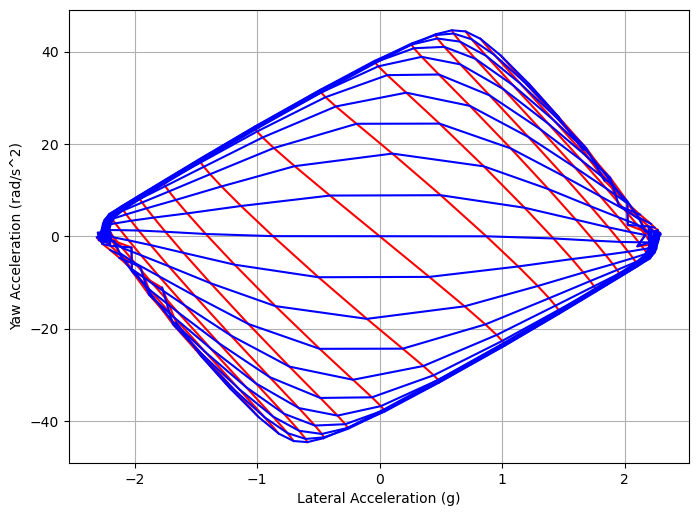

In [189]:
df = pd.read_csv("MMM.csv")

fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(111)

for x in df["body_slip"].unique():
    df2 = df[df["body_slip"] == x]
    lat_accel = list(df2["vehicle_accelerations_NTB_1"]/9.81)
    yaw_accel = list(df2["yaw_acceleration"])
    mid_point = int(len(lat_accel)/2)

    ax.plot(lat_accel, yaw_accel, 'r')
    #ax.text(lat_accel[mid_point], yaw_accel[mid_point], '{0:.2f}'.format(x*180/math.pi))

for x in df["steered_angle"].unique():
    if True:#x == 0:
        df2 = df[(df["steered_angle"] == x)]
        ax.plot(df2["vehicle_accelerations_NTB_1"]/9.81, df2["yaw_acceleration"], 'b')
ax.grid()
ax.set_ylabel("Yaw Acceleration (rad/s^2)")
ax.set_xlabel("Lateral Acceleration (g)")

abs(df["yaw_acceleration"]).min()

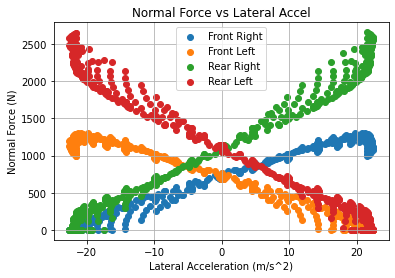

In [198]:
import math
plt.scatter(df["vehicle_accelerations_NTB_1"], df["front_left_tire_tire_centric_forces_2"], label = "Front Right")
plt.scatter(df["vehicle_accelerations_NTB_1"], df["front_right_tire_tire_centric_forces_2"], label = "Front Left")
plt.scatter(df["vehicle_accelerations_NTB_1"], df["rear_left_tire_tire_centric_forces_2"], label = "Rear Right")
plt.scatter(df["vehicle_accelerations_NTB_1"], df["rear_right_tire_tire_centric_forces_2"], label = "Rear Left")
plt.title("Normal Force vs Lateral Accel")
plt.grid()
plt.ylabel("Normal Force (N)")
plt.xlabel("Lateral Acceleration (m/s^2)")
plt.legend()

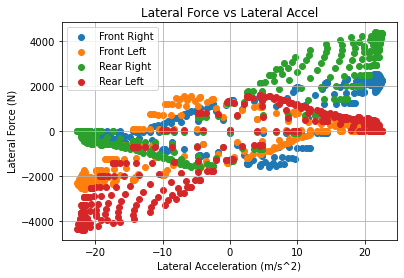

In [199]:
plt.scatter(df["vehicle_accelerations_NTB_1"], df["front_left_tire_vehicle_centric_forces_1"], label = "Front Right")
plt.scatter(df["vehicle_accelerations_NTB_1"], df["front_right_tire_vehicle_centric_forces_1"], label = "Front Left")
plt.scatter(df["vehicle_accelerations_NTB_1"], df["rear_left_tire_vehicle_centric_forces_1"], label = "Rear Right")
plt.scatter(df["vehicle_accelerations_NTB_1"], df["rear_right_tire_vehicle_centric_forces_1"], label = "Rear Left")
plt.title("Lateral Force vs Lateral Accel")
plt.grid()
plt.ylabel("Lateral Force (N)")
plt.xlabel("Lateral Acceleration (m/s^2)")
plt.legend()

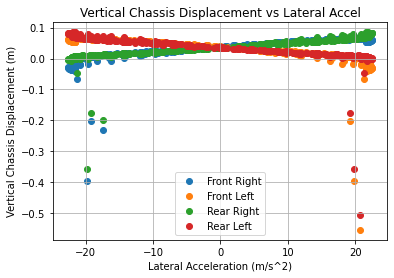

In [200]:
plt.scatter(df["vehicle_accelerations_NTB_1"], df["front_left_tire_z_c"], label = "Front Right")
plt.scatter(df["vehicle_accelerations_NTB_1"], df["front_right_tire_z_c"], label = "Front Left")
plt.scatter(df["vehicle_accelerations_NTB_1"], df["rear_left_tire_z_c"], label = "Rear Right")
plt.scatter(df["vehicle_accelerations_NTB_1"], df["rear_right_tire_z_c"], label = "Rear Left")
plt.title("Vertical Chassis Displacement vs Lateral Accel")
plt.grid()
plt.ylabel("Vertical Chassis Displacement (m)")
plt.xlabel("Lateral Acceleration (m/s^2)")
plt.legend()

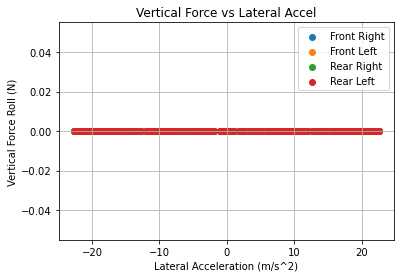

In [201]:
plt.scatter(df["vehicle_accelerations_NTB_1"], df["front_left_tire_f_roll"], label = "Front Right")
plt.scatter(df["vehicle_accelerations_NTB_1"], df["front_right_tire_f_roll"], label = "Front Left")
plt.scatter(df["vehicle_accelerations_NTB_1"], df["rear_left_tire_f_roll"], label = "Rear Right")
plt.scatter(df["vehicle_accelerations_NTB_1"], df["rear_right_tire_f_roll"], label = "Rear Left")
plt.title("Vertical Force vs Lateral Accel")
plt.grid()
plt.ylabel("Vertical Force Roll (N)")
plt.xlabel("Lateral Acceleration (m/s^2)")
plt.legend()

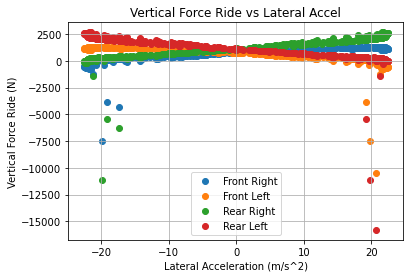

In [202]:
plt.scatter(df["vehicle_accelerations_NTB_1"], df["front_left_tire_f_heave"], label = "Front Right")
plt.scatter(df["vehicle_accelerations_NTB_1"], df["front_right_tire_f_heave"], label = "Front Left")
plt.scatter(df["vehicle_accelerations_NTB_1"], df["rear_left_tire_f_heave"], label = "Rear Right")
plt.scatter(df["vehicle_accelerations_NTB_1"], df["rear_right_tire_f_heave"], label = "Rear Left")
plt.title("Vertical Force Ride vs Lateral Accel")
plt.grid()
plt.ylabel("Vertical Force Ride (N)")
plt.xlabel("Lateral Acceleration (m/s^2)")
plt.legend()

No handles with labels found to put in legend.


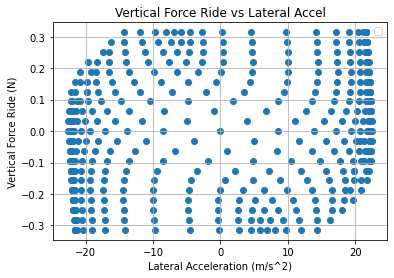

In [195]:
plt.scatter(df["vehicle_accelerations_NTB_1"], df["steered_angle"])
plt.title("Vertical Force Ride vs Lateral Accel")
plt.grid()
plt.ylabel("Vertical Force Ride (N)")
plt.xlabel("Lateral Acceleration (m/s^2)")
plt.legend()

In [196]:
x=df[df["vehicle_accelerations_NTB_1"] == df["vehicle_accelerations_NTB_1"].max()].iloc[0]
# for name, y in x.items():
#     print(name + ": " +str(y))
# print(x["y_double_dot"]/9.81)
# print(x["yaw_acceleration"])
# print(x["front_left_f_roll"])
# print(x["front_right_f_heave"]-x["front_left_f_heave"])
# print(x["rear_right_f_heave"]-x["rear_left_f_heave"])
# print(x["roll"]*180/math.pi)
print(x["front_left_tire_vehicle_centric_forces_0"])
print(x["front_left_tire_vehicle_centric_forces_1"])
print(x["front_left_tire_vehicle_centric_forces_2"])
print(x["rear_left_tire_vehicle_centric_forces_0"])
print(x["rear_left_tire_vehicle_centric_forces_1"])
print(x["rear_left_tire_vehicle_centric_forces_2"])
# print(x["front_right_tire_centric_forces_2"])
# print(x["rear_left_tire_centric_forces_2"])
# print(x["rear_right_tire_centric_forces_2"])
# print(x["front_left_tire_centric_forces_2"])
# print(x["front_right_tire_centric_forces_2"])
# print(x["rear_left_tire_centric_forces_2"])
# print(x["rear_right_tire_centric_forces_2"])

-802.3689491081027
2228.6654924112217
1109.2638151469466
-1406.8884398887894
4329.957390087903
2589.356830765969


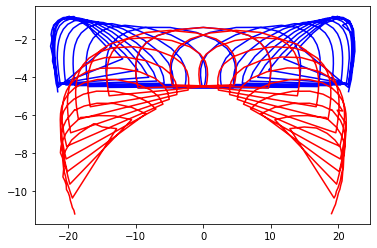

In [197]:
plt.plot(df["vehicle_accelerations_NTB_1"], df["vehicle_accelerations_NTB_0"], 'b')
plt.plot(df["y_double_dot"], df["x_double_dot"], 'r')